##### Find cars on an image

In [1]:
import numpy as np
import pickle
import cv2
import glob
import os
import time
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pandas as pd
from moviepy.editor import VideoFileClip
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label

##### Data collection

In [2]:
car_images = glob.glob('./training_data/vehicles/*/*/*.png')
noncar_images = glob.glob('./training_data/non_vehicles/*/*/*.png')

##### Set hog parameters, result of hog parameter exploration step

In [3]:
hog_params = {}
hog_params['cspace'] = 'YUV'
hog_params['orient'] = 10
hog_params['pix_per_cell'] = 16
hog_params['cell_per_block'] = 2
hog_params['hog_channel'] = "ALL"

##### Train using SVC after getting hog features

In [4]:
from vehicle_detection import classifier
g_svc, hog_svc_data = classifier.train_hog_features(car_images, noncar_images, hog_params)

55.82 Seconds to extract HOG features...
Using: 10 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 1080
1.24 Seconds to train SVC...
Test Accuracy of SVC =  0.9828
My SVC predicts:  [ 1.  1.  0.  1.  0.  1.  0.  1.  1.  0.]
For these 10 labels:  [ 1.  1.  0.  1.  0.  1.  0.  1.  1.  0.]
0.02805 Seconds to predict 10 labels with SVC


##### Begin sliding window search

In [5]:
from vehicle_detection import sliding_window

##### Set parameters for window, a set of choice and try on an image

In [6]:
g_ystart = 400
g_ystop = 650
g_scale = 1.5

g_colorspace = hog_params['cspace']
g_hog_channel = hog_params['hog_channel']
g_orient = hog_params['orient']
g_pix_per_cell = hog_params['pix_per_cell']
g_cell_per_block = hog_params['cell_per_block']

(720, 1280, 3)

[((48, 400), (144, 496)),
 ((144, 448), (240, 544)),
 ((192, 400), (288, 496)),
 ((816, 400), (912, 496)),
 ((864, 400), (960, 496)),
 ((1056, 400), (1152, 496)),
 ((1104, 400), (1200, 496)),
 ((1152, 400), (1248, 496))]

8 rectangles found in image


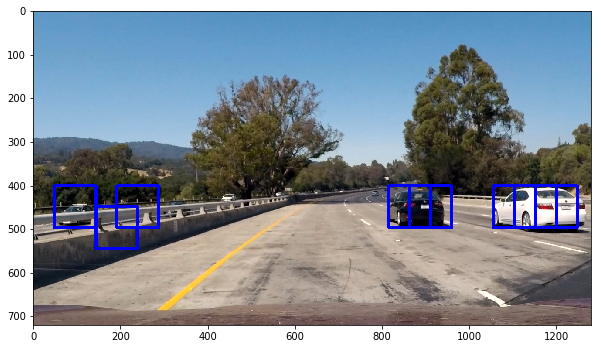

In [7]:
img = cv2.imread('./test_images/test1.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
test_image = img.copy()

display(img.shape)
car_windows = sliding_window.detect_cars(img, g_ystart, g_ystop, g_scale, g_svc, g_colorspace, g_hog_channel, 
                          g_orient, g_pix_per_cell, g_cell_per_block)
display(car_windows)
print(len(car_windows), 'rectangles found in image')
car_detected_img = sliding_window.draw_boxes(img, car_windows)
plt.figure(figsize=(10,10))
plt.imshow(car_detected_img)
plt.show()

##### Function to perform an exhaustive search, I have chosen the coorodinates and scaling by manual observation of ares that will have cars

In [8]:
def car_location_exploration(img, ystart, ystop, img_scale):
    car_windows = []
    for start in ystart:
            for stop in ystop:
                for scale in img_scale:
                    g_ystart = start
                    g_ystop = stop
                    g_scale = scale
                    
                    car_windows.append(sliding_window.detect_cars(img, g_ystart, g_ystop, g_scale, g_svc, g_colorspace, g_hog_channel, 
                              g_orient, g_pix_per_cell, g_cell_per_block))
    return car_windows

In [9]:
ystart = [300,350,400, 425]
ystop = [500, 550, 600, 650]
img_scale = [1, 1.5, 2, 2.5]

car_windows = car_location_exploration(test_image, ystart, ystop, img_scale)

##### Draw detected rectangles

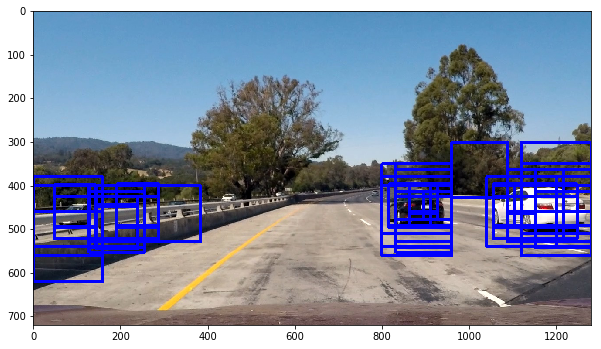

In [10]:
# apparently this is the best way to flatten a list of lists
car_positions = [item for sublist in car_windows for item in sublist] 
test_img_cars = sliding_window.draw_boxes(test_image, car_positions)
plt.figure(figsize=(10,10))
plt.imshow(test_img_cars)
plt.show()

##### Test heat maps

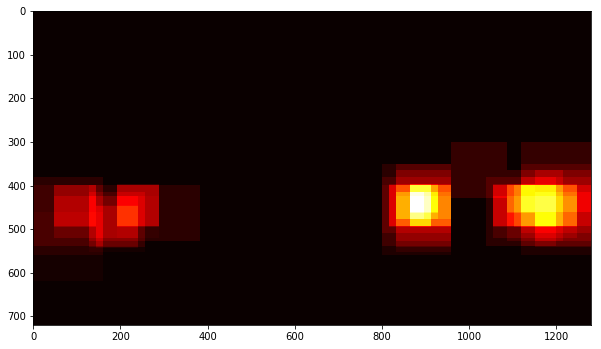

In [11]:
# Test out the heatmap
heatmap_img = np.zeros_like(test_image[:,:,0])
heatmap_img = sliding_window.add_heat(heatmap_img, car_positions)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')
plt.show()

##### Apply threshold to heat map

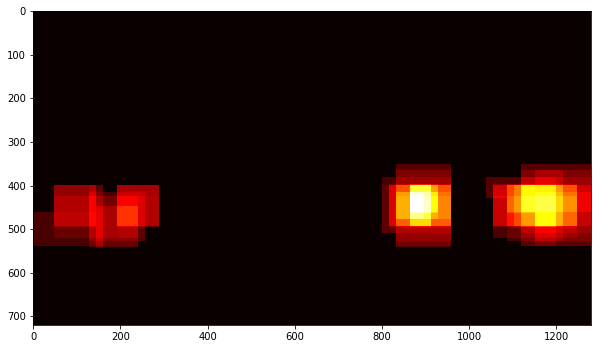

In [12]:
heatmap_img = sliding_window.apply_threshold(heatmap_img, 5)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')
plt.show()

##### Apply scipy labels to heatmaps

3 cars found


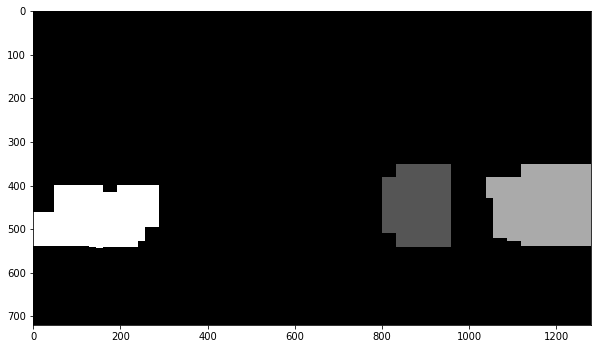

In [13]:
labels = label(heatmap_img)
plt.figure(figsize=(10,10))
plt.imshow(labels[0], cmap='gray')
print(labels[1], 'cars found')
plt.show()

##### Draw bounding boxes  for labels

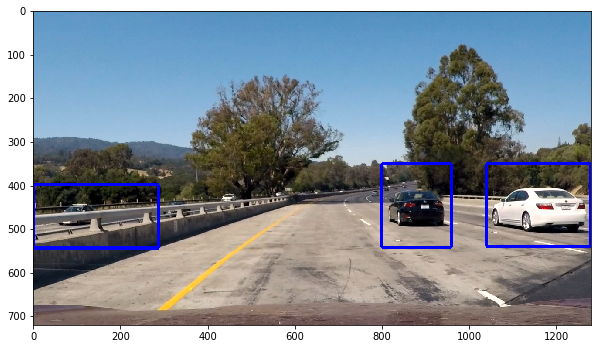

In [14]:
# Draw bounding boxes on a copy of the image
draw_img = sliding_window.draw_labeled_bboxes(np.copy(test_image), labels)
# Display the image
plt.figure(figsize=(10,10))
plt.imshow(draw_img)
plt.show()

In [15]:
g_ystart = [350,400, 425]
g_ystop = [500, 550, 600, 650]
g_img_scale = [1, 1.5, 2, 2.5]

g_threshold = 10

In [22]:
def detect_car_pipeline(test_image, plot=False):

    f, (axis0, axis1, axis2, axis3, axis4) = plt.subplots(5, 1, figsize=(20, 30))
    axis0.imshow(test_image)
    axis0.set_title('Blurred image', fontsize=14)
    
    car_windows = car_location_exploration(test_image, g_ystart, g_ystop, g_img_scale)
    # apparently this is the best way to flatten a list of lists
    car_positions = [item for sublist in car_windows for item in sublist] 
    test_img_cars = sliding_window.draw_boxes(test_image, car_positions)
    axis1.imshow(test_img_cars)
    axis1.set_title('Sliding window results', fontsize=14)
    
    # Test out the heatmap
    heatmap_img = np.zeros_like(test_image[:,:,0])
    heatmap_img = sliding_window.add_heat(heatmap_img, car_positions)
    axis2.imshow(heatmap_img, cmap='hot')
    axis2.set_title('Add heatmap', fontsize=14)
 
    thresholded_img = sliding_window.apply_threshold(heatmap_img, g_threshold)
    axis3.imshow(thresholded_img, cmap='gray')
    axis3.set_title('Thresholded image', fontsize=14)
    
    labels = label(thresholded_img)
    
    # Draw bounding boxes on a copy of the image
    draw_img = sliding_window.draw_labeled_bboxes(np.copy(test_image), labels)   
    # Display the image
    axis4.imshow(draw_img)
    axis4.set_title('Cars detected', fontsize=14)

    if plot:
        return plt.figure()
    else:
        return draw_img

test1.jpg


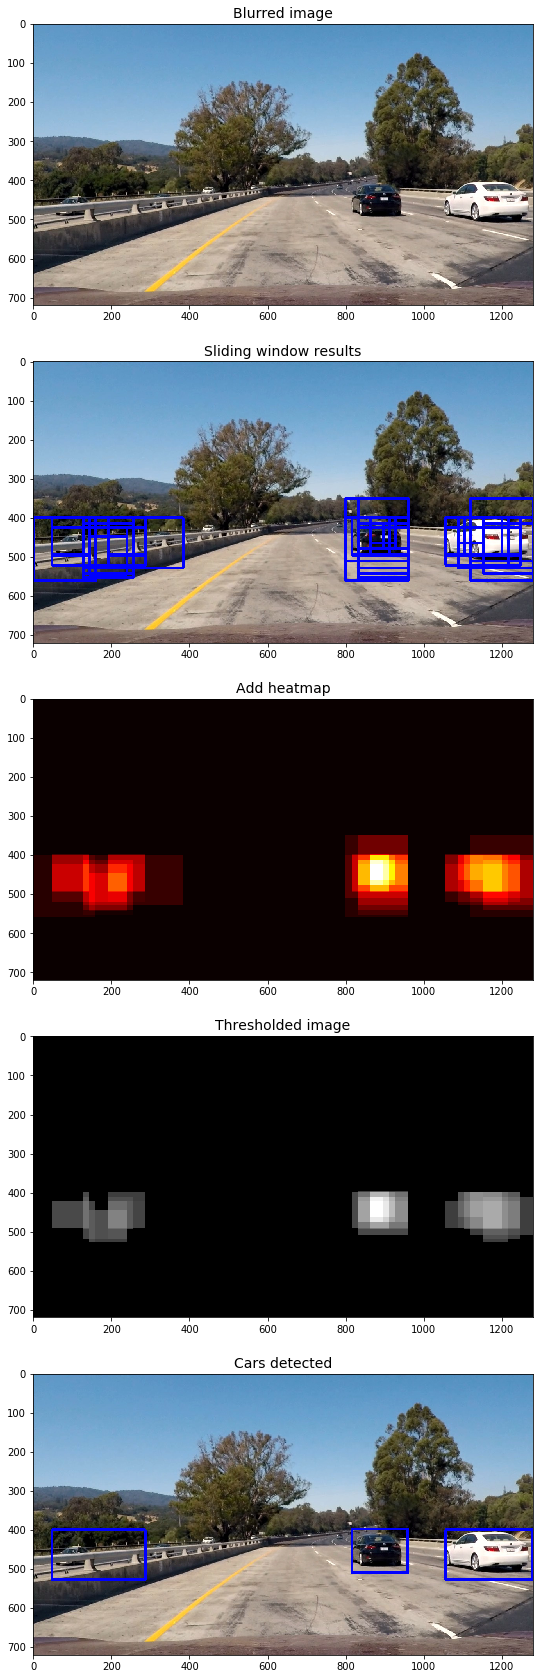

test2.jpg


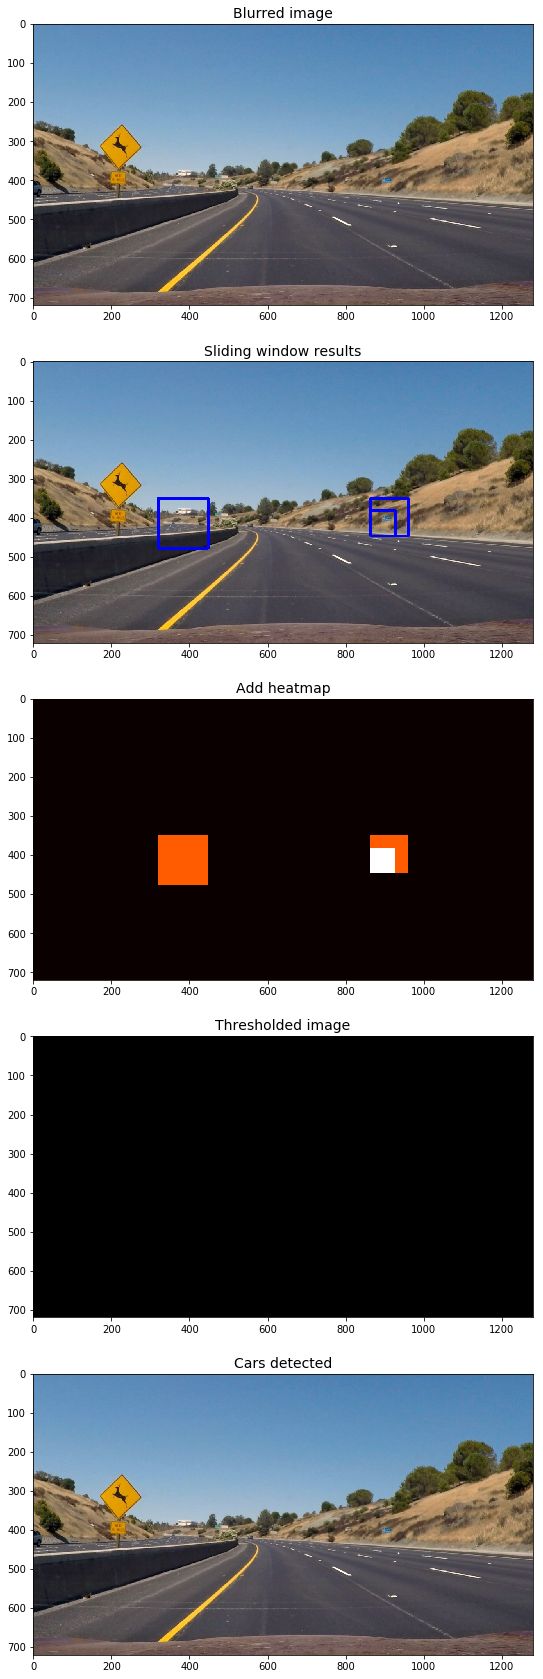

test3.jpg


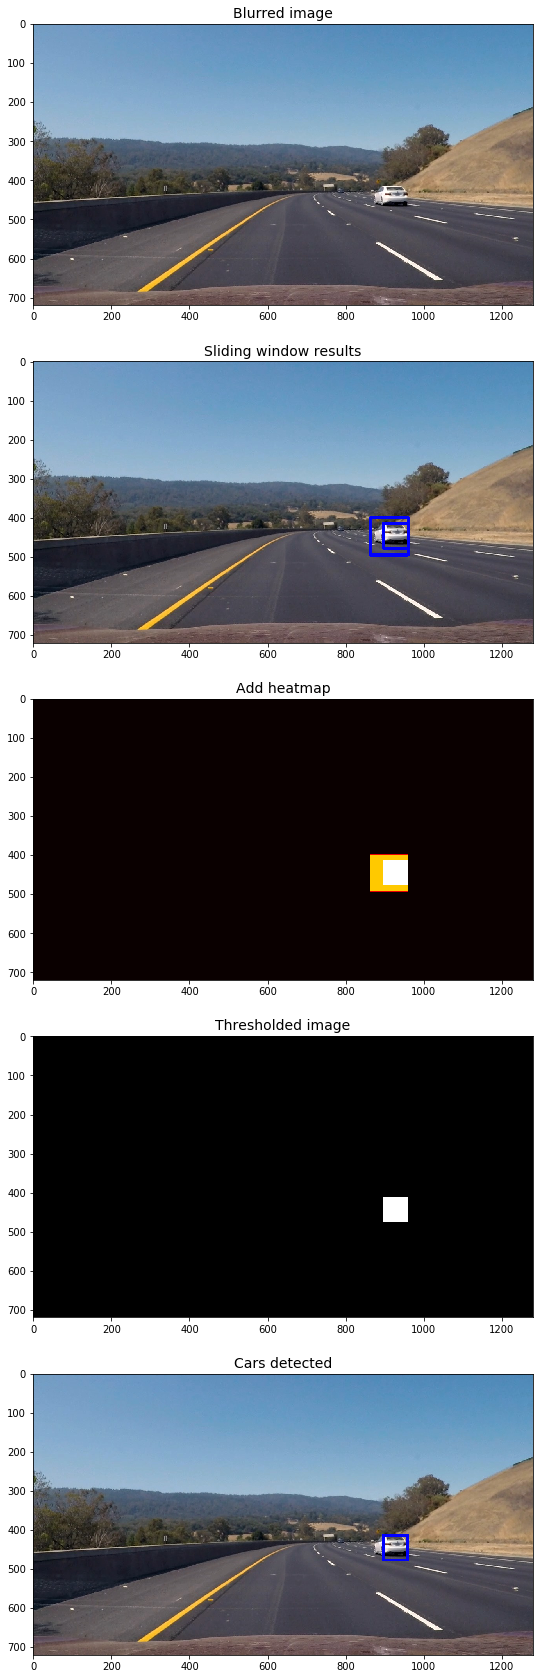

test4.jpg


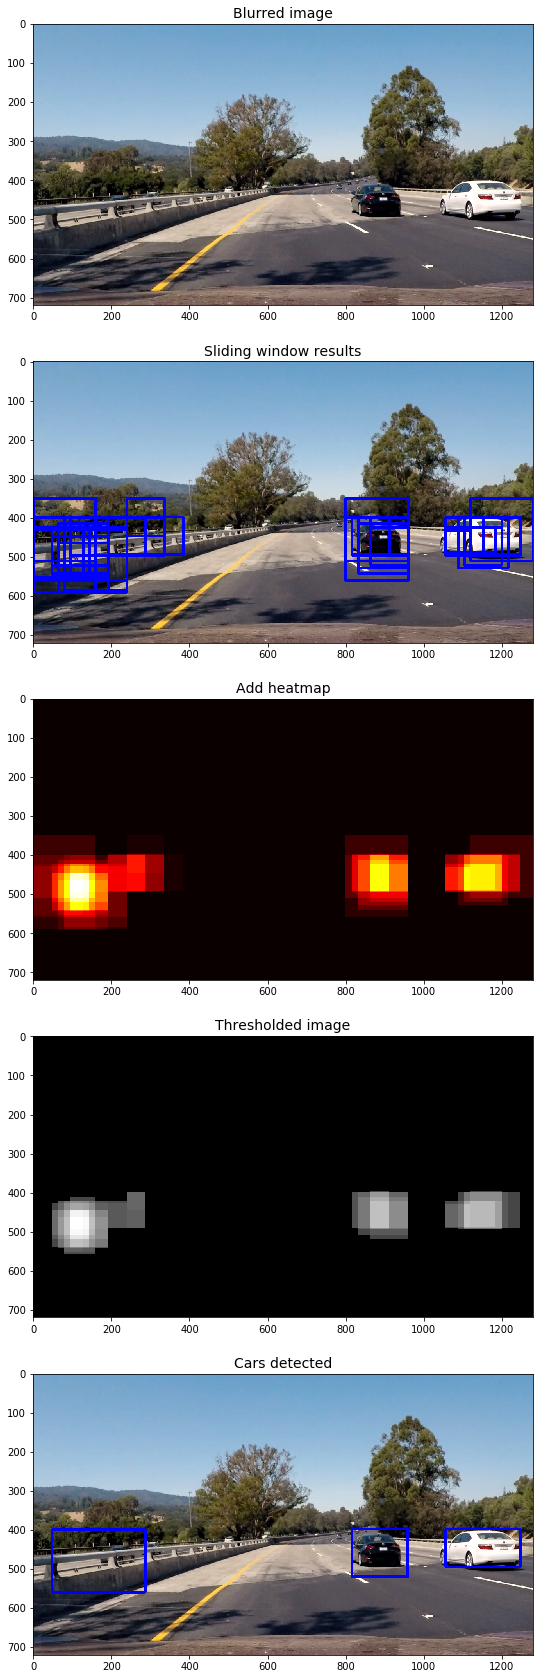

test5.jpg


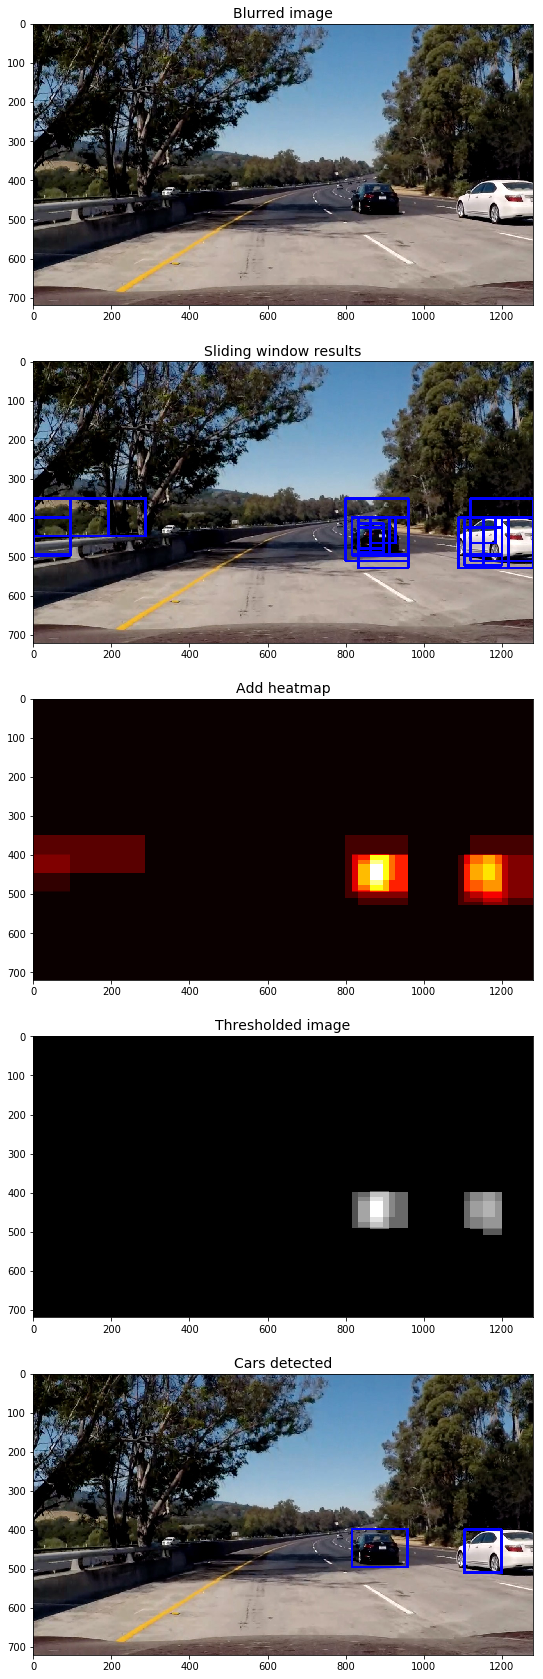

test6.jpg


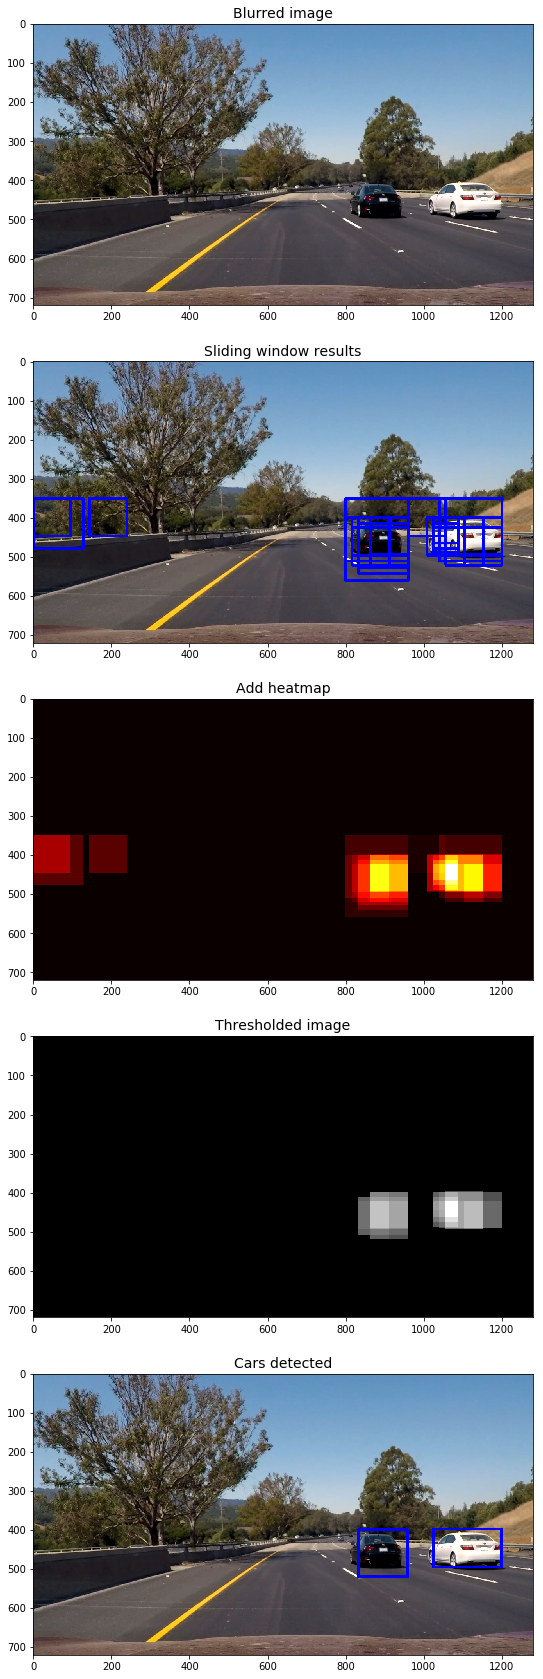

In [23]:
test_images = glob.glob('./test_images/test*.jpg')
out_dir = ('./output_images')

for idx, img in enumerate(test_images):
    image_name = img.split('/')[1].split('\\')[1]
    print(image_name)
    image = cv2.imread(img)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    car_image = detect_car_pipeline(image, plot=True)

    if not os.path.exists(out_dir):
        os.makedirs(out_dir)
    plt.show(car_image)
    car_image.savefig('{}/{}.jpg'.format(out_dir, image_name))

In [24]:
from moviepy.editor import VideoFileClip
test_out_file = 'test_video_out.mp4'
clip_test = VideoFileClip('test_video.mp4')
clip_test_out = clip_test.fl_image(detect_car_pipeline)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 38/39 [02:24<00:03,  3.44s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

Wall time: 2min 25s


In [25]:
from moviepy.editor import VideoFileClip
test_out_file = 'project_video_out.mp4'
clip_test = VideoFileClip('project_video.mp4')
clip_test_out = clip_test.fl_image(detect_car_pipeline)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [1:12:21<00:03,  3.71s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

Wall time: 1h 12min 22s
